1. Try optimal transport reprogramming data
2. Add similarity matrix
3. Use log only in loss function (cant pass first iter, - outputs of neural block)

#### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

#### Test

In [3]:
from clonaltrans import main, config
device = torch.device("cuda:3")

config = config.Configuration()
config.learning_rate = 0.05
config.num_epochs = 2000
print (vars(config))

model = main.main(config, device)

{'gpu': 3, 'activation': 'gelu', 'seed': 42, 'alpha': 0.01, 'beta': 0.01, 'num_epochs': 2000, 'learning_rate': 0.05, 'paga_diagonal': True}
Topology graph loaded.
Input cell data (num_timepoints, num_clones, num_populations) loaded.
Background reference cells generated.
tensor(1873976.1250, device='cuda:3')


Delta 0.000, BaseK 0.000, Observation 0.000: 100%|██████████| 2000/2000 [1:27:28<00:00,  2.62s/it]


#### Fit Observations

There are 2 observed timepoints except the inital time.


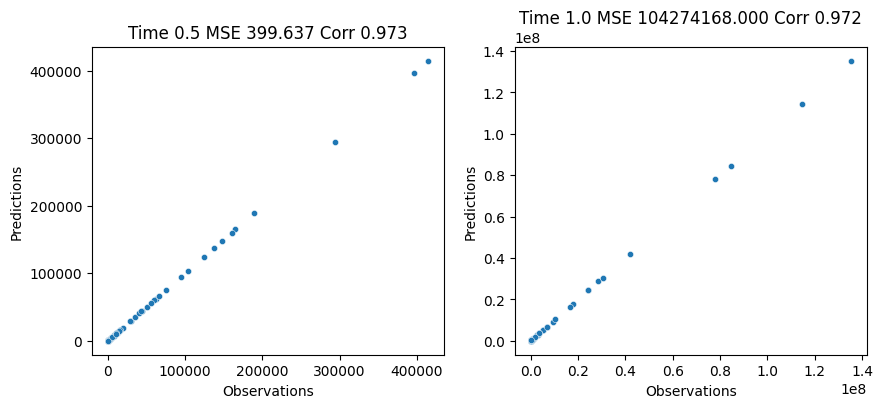

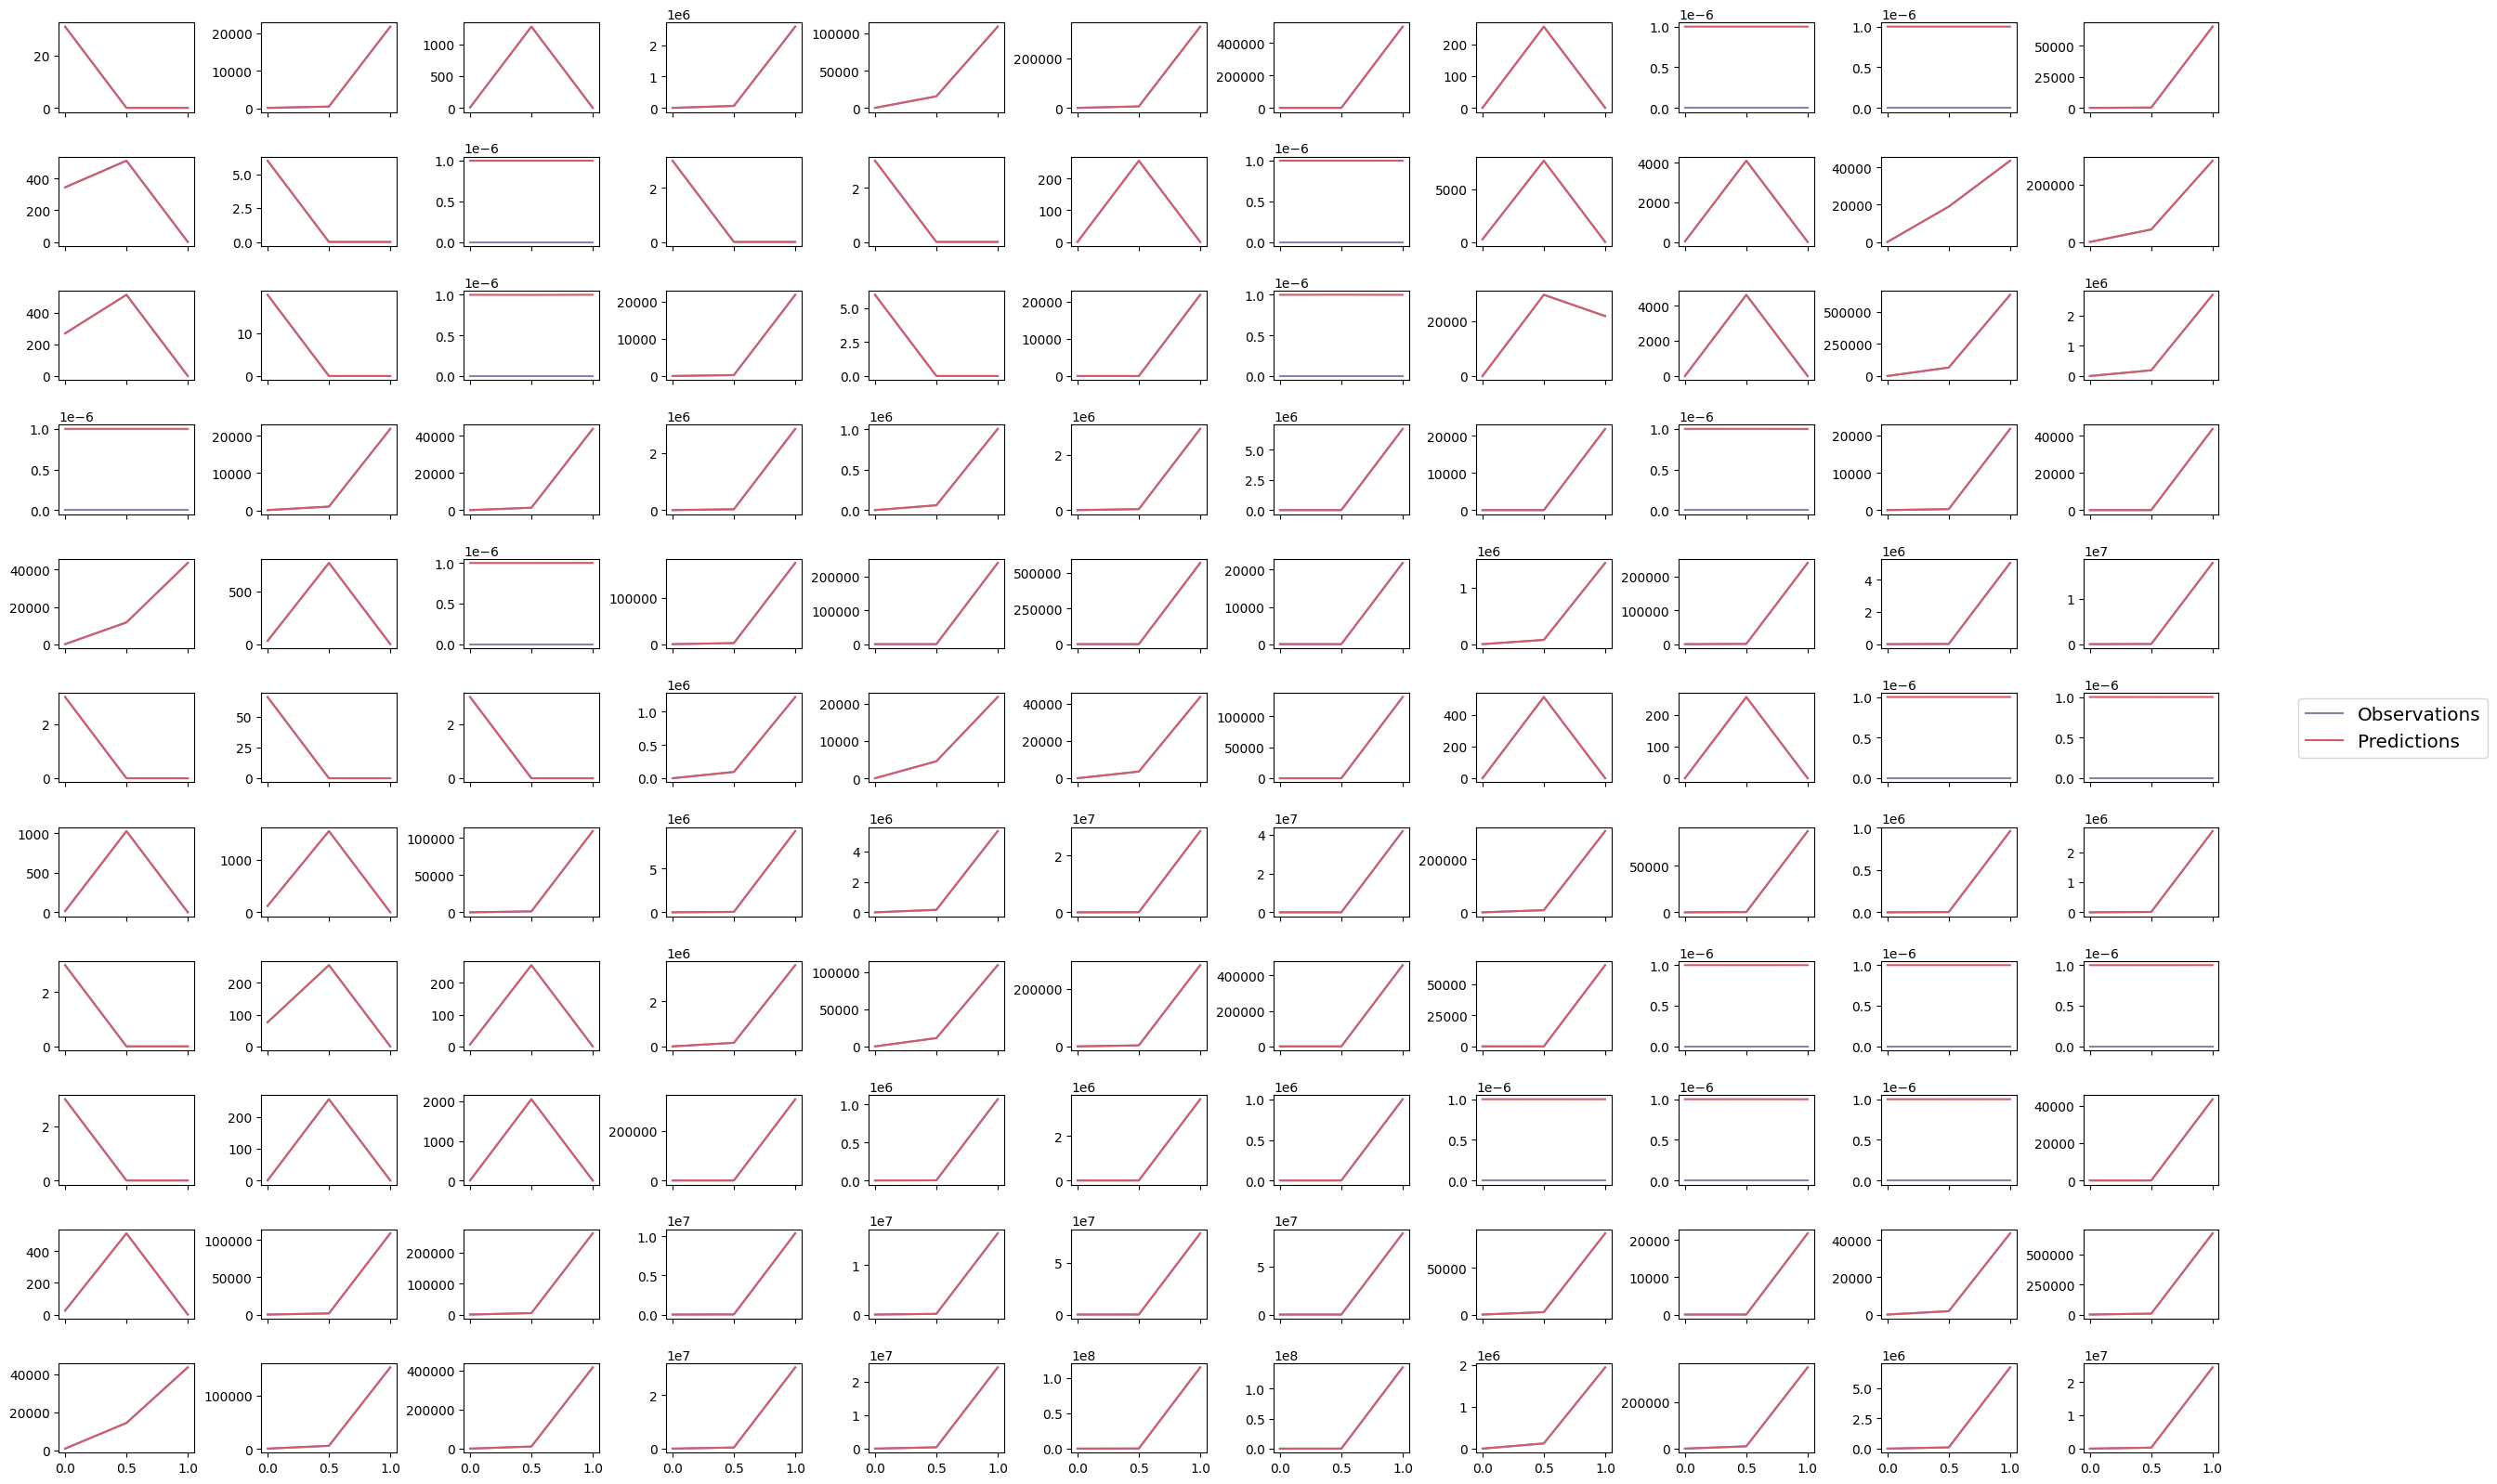

In [4]:
from clonaltrans import pl
t_observed = torch.tensor([3.0, 10.0, 17.0]).to(device)
t_observed = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])
pl.eval_predictions(model, t_observed)

#### Timepoints Predictions

In [3]:
model = torch.load('./examples/Gelu_Alpha0.01_Beta0.01_Epoch2000_LR0.05_Log/model.pt')
device = torch.device("cuda:3")

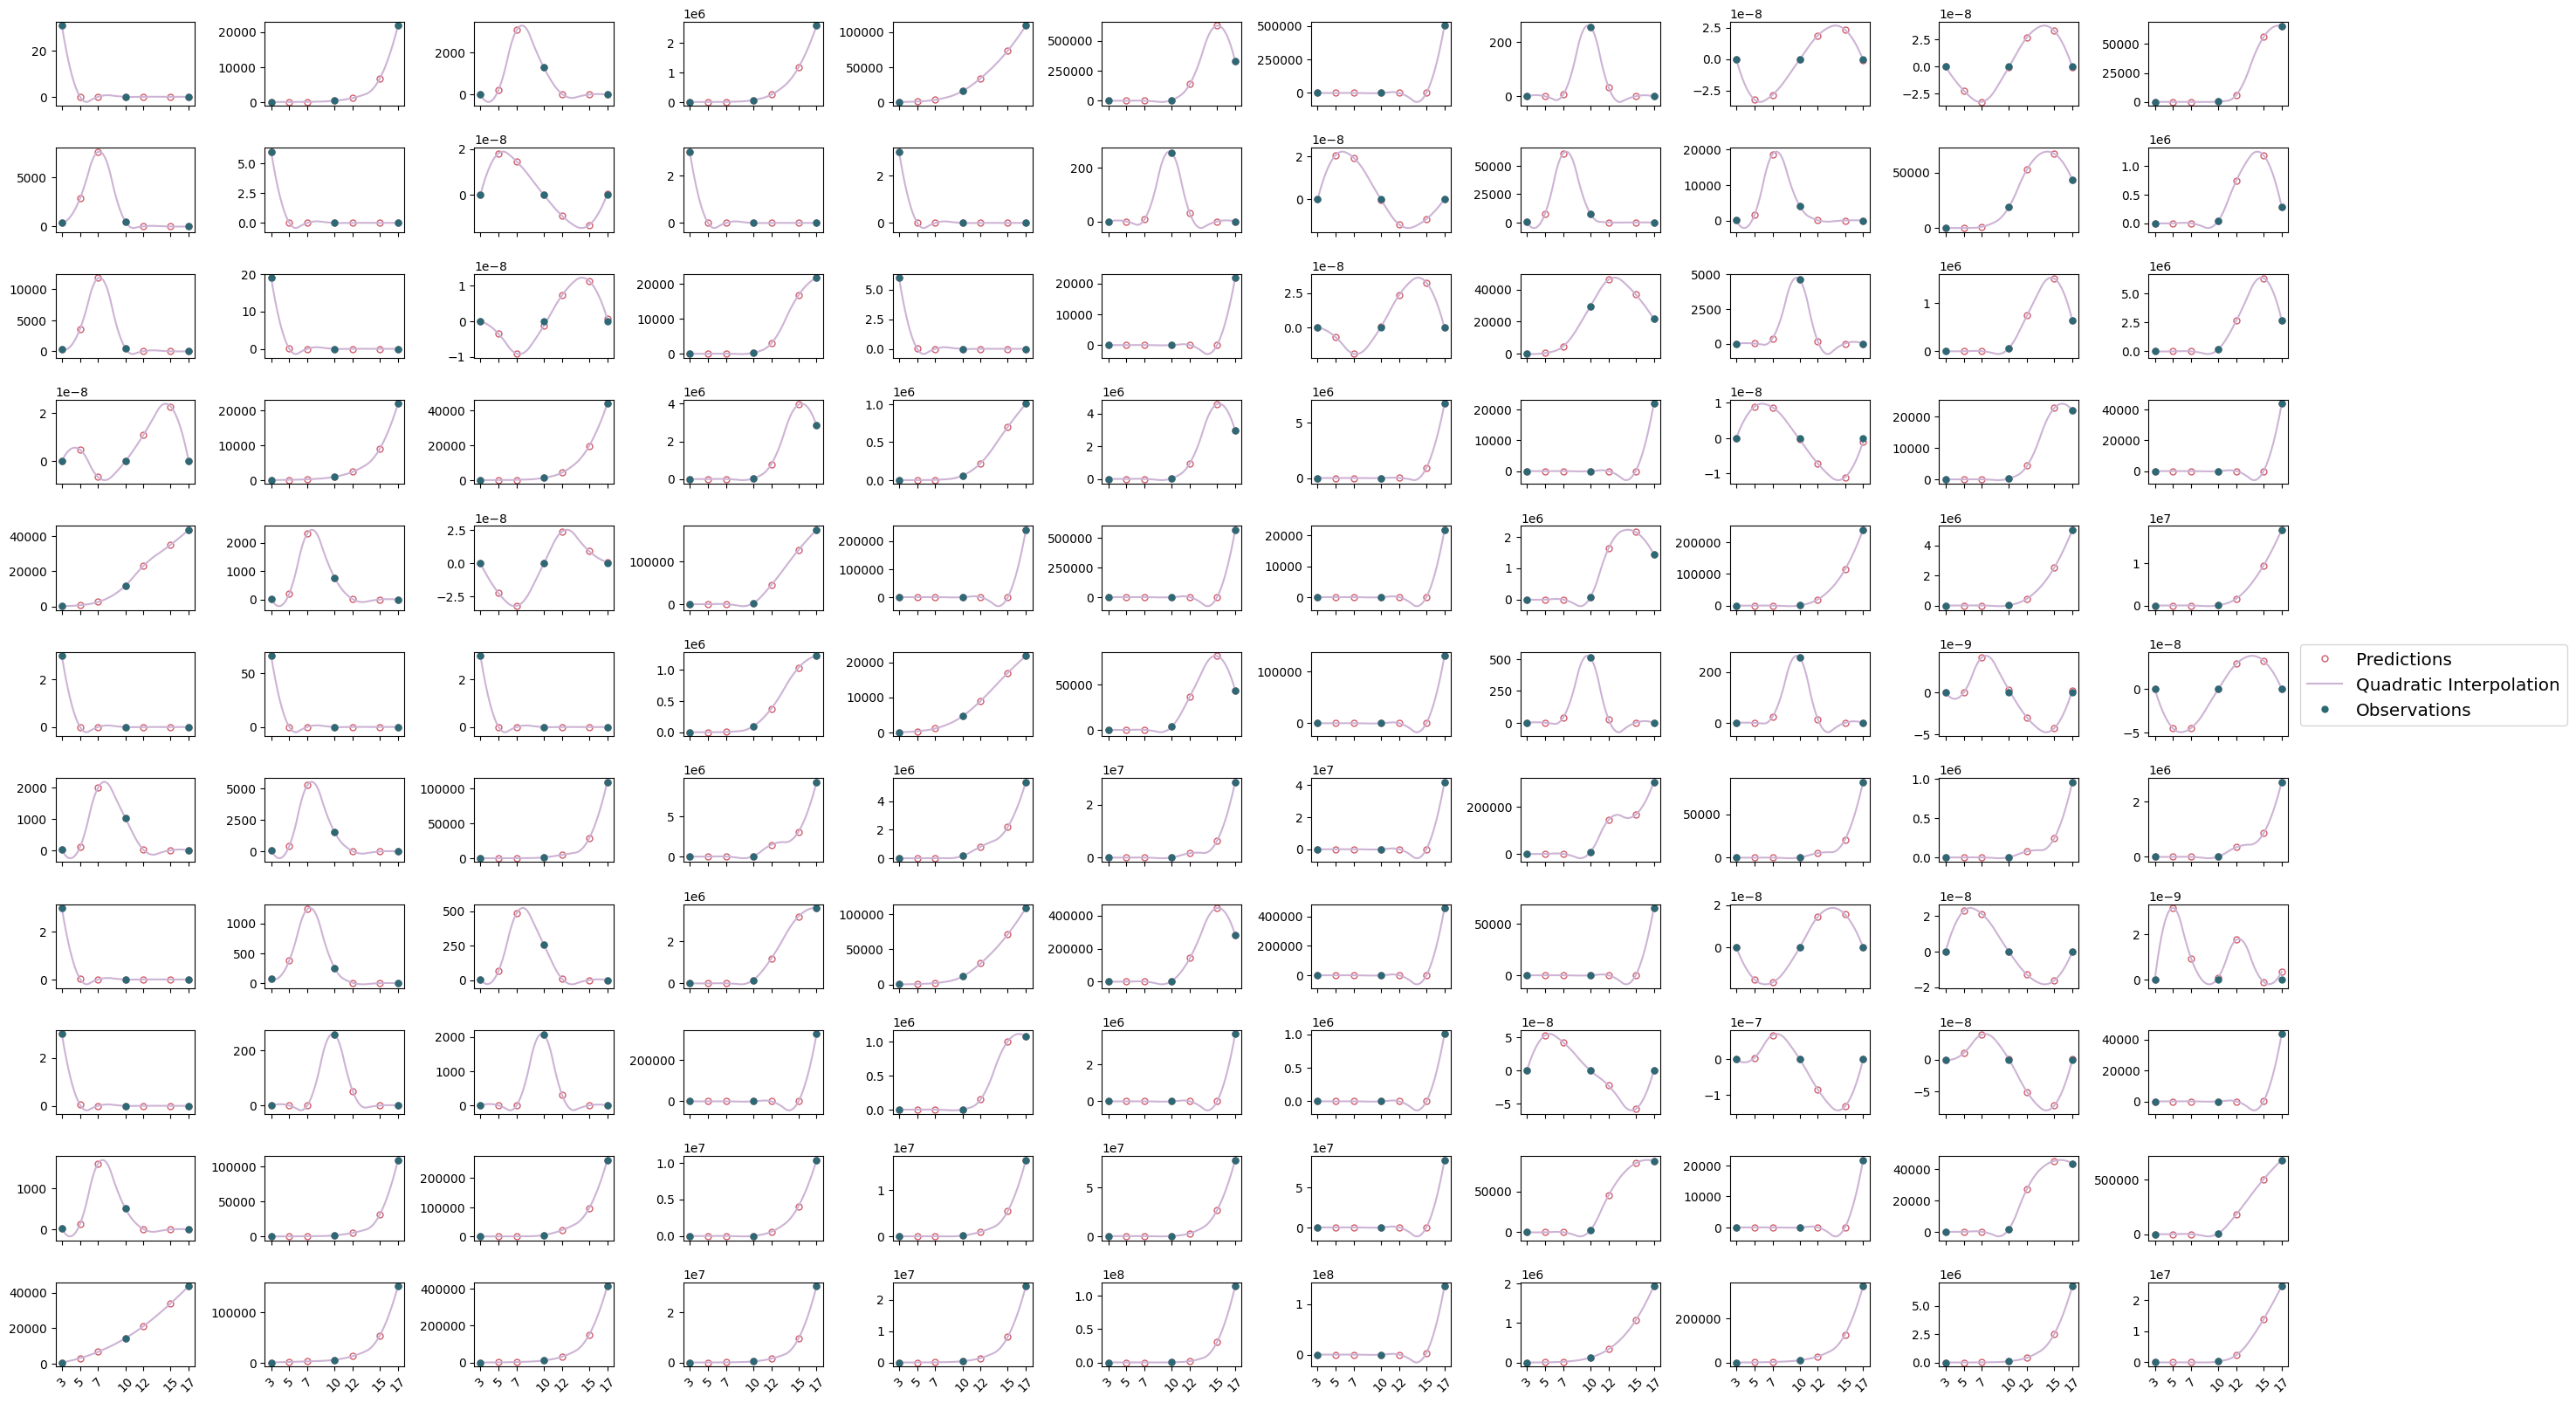

In [4]:
from clonaltrans import pl
t_observed = torch.tensor([3.0, 10.0, 17.0]).to(device)
# t_observed = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])

t_pred = torch.tensor([3.0, 5.0, 7.0, 10.0, 12.0, 15.0, 17.0]).to(device)
t_pred_norm = (t_pred - t_pred[0]) / (t_pred[-1] - t_pred[0])
predictions = model.eval_model(t_pred_norm)
pl.grid_visual(model.N, predictions, t_observed, t_pred)

#### Timepoints Smoothing

In [5]:
model = torch.load('./examples/Gelu_Alpha0.01_Beta0.01_Epoch2000_LR0.05_Log/model.pt')
device = torch.device("cuda:3")

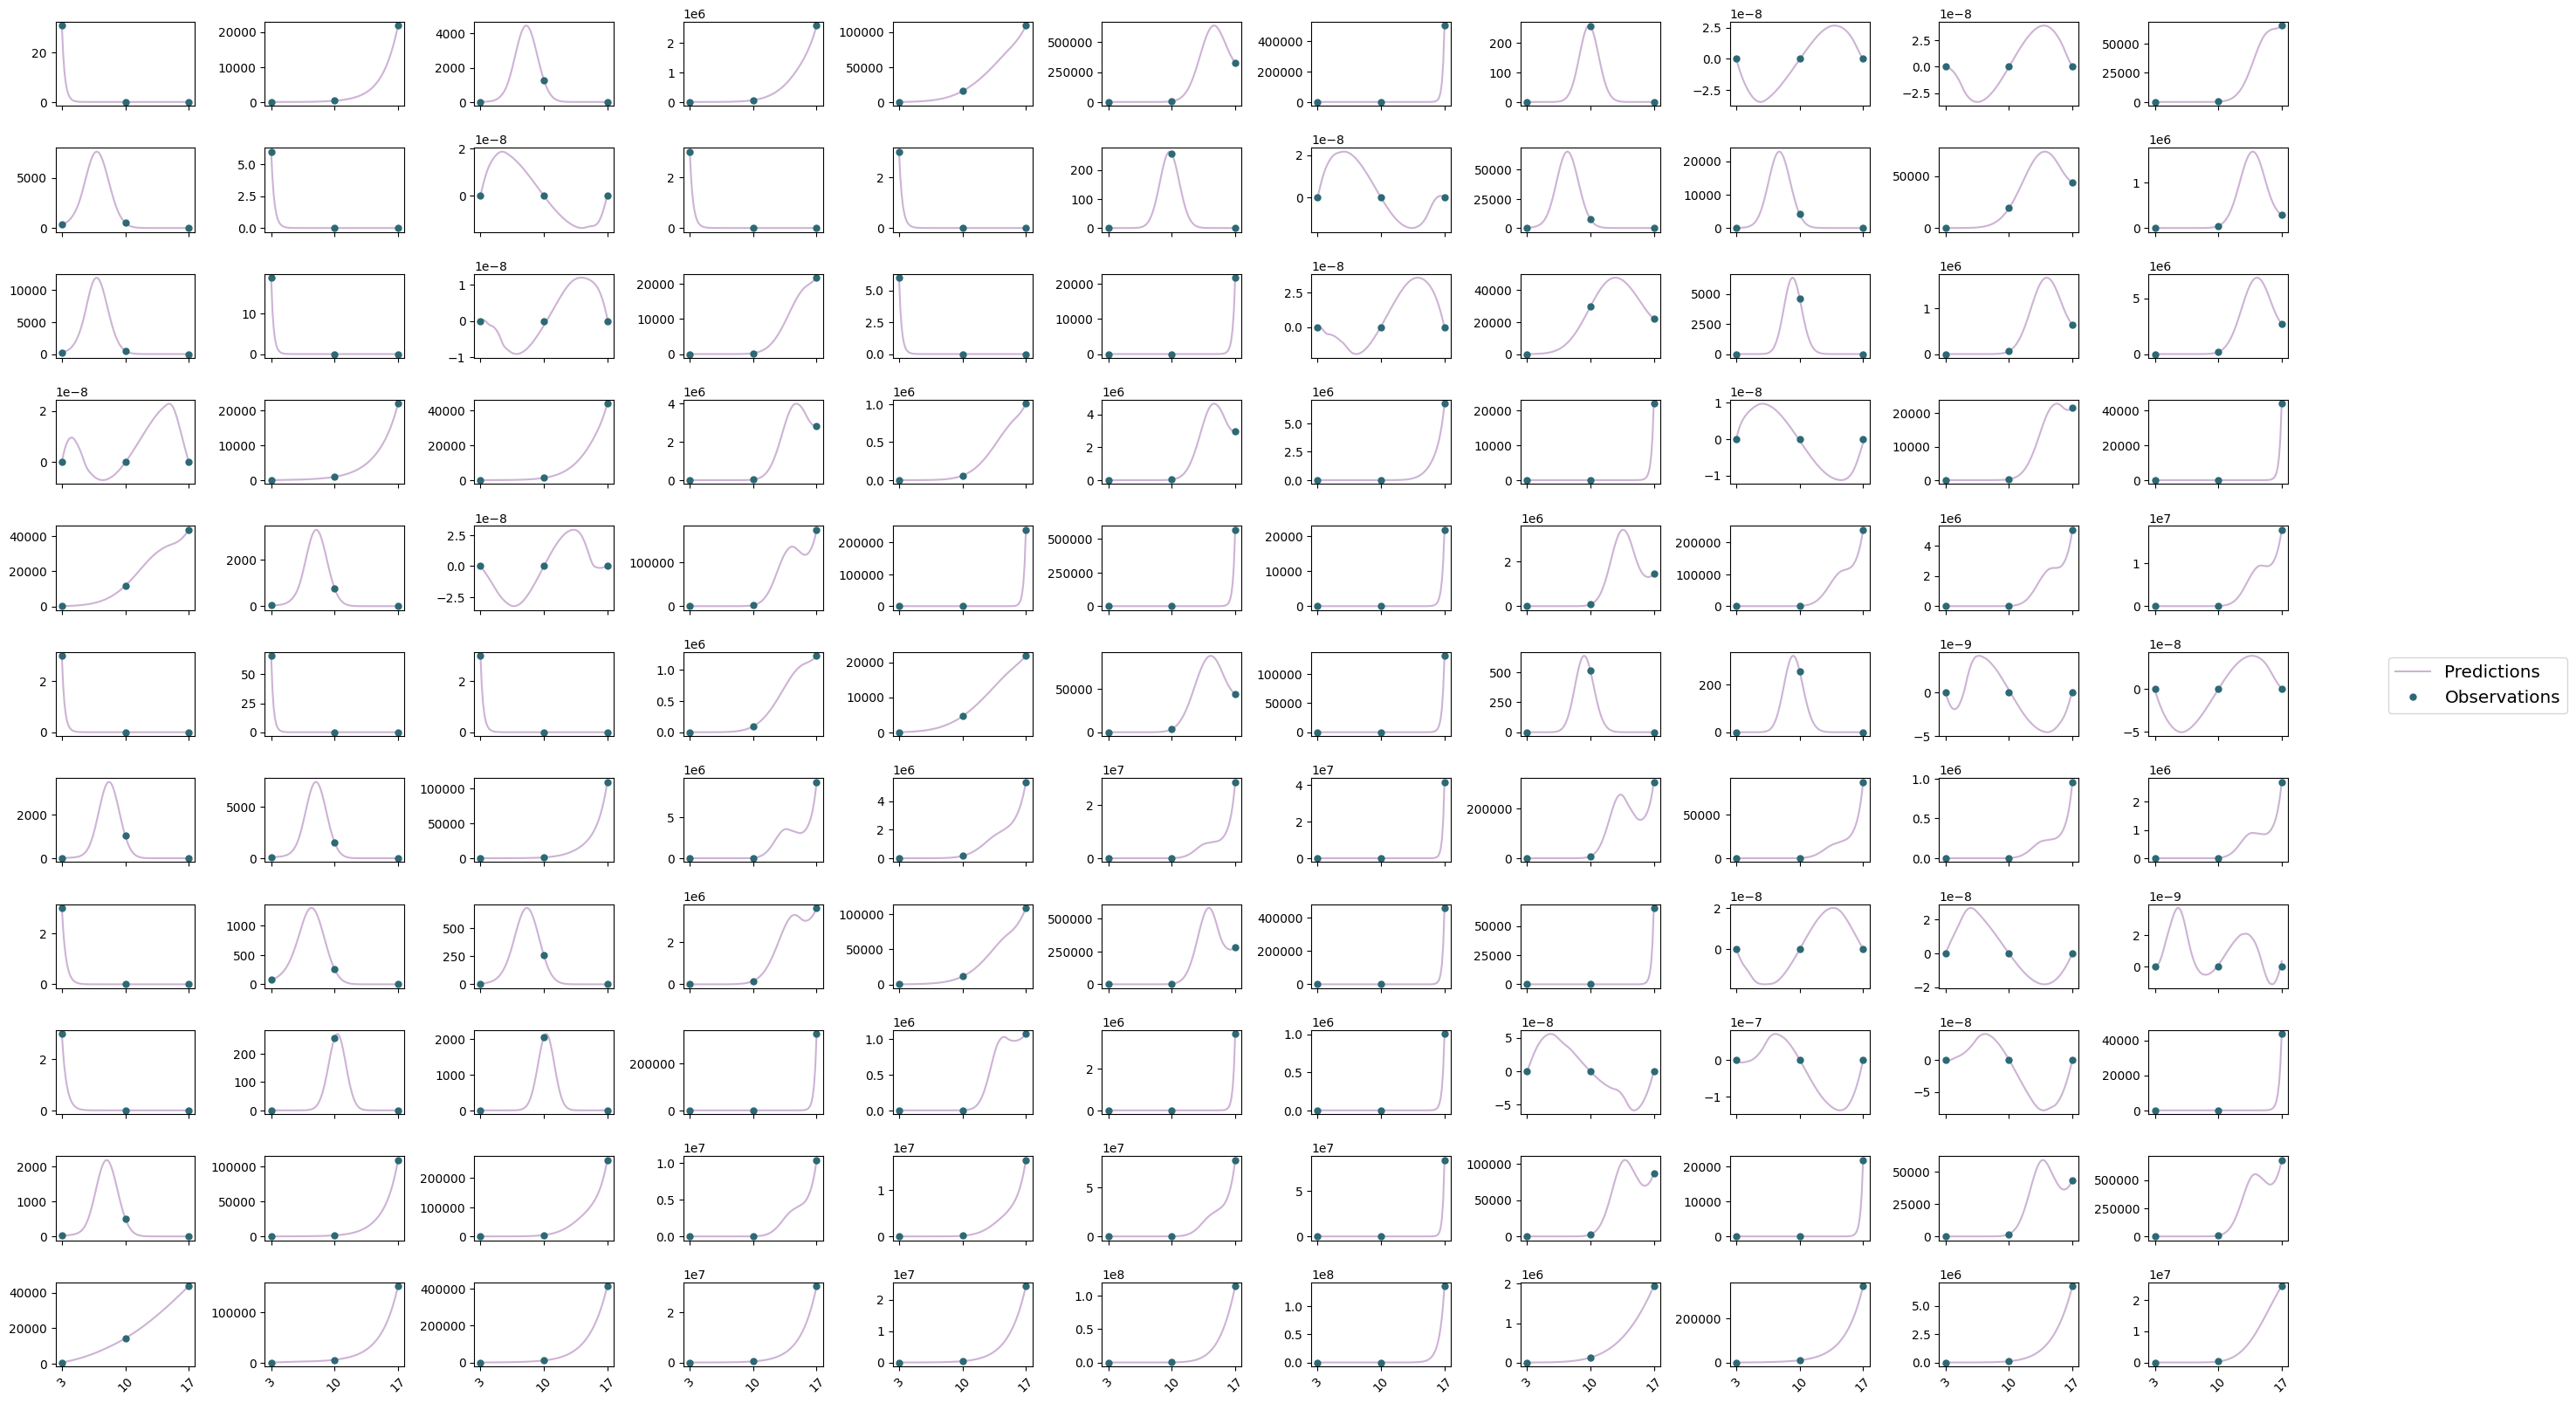

In [6]:
from clonaltrans import pl
t_observed = torch.tensor([3.0, 10.0, 17.0]).to(device)
# t_observed = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])

x = np.linspace(3, 17, 100)
t_pred = torch.tensor(x).to(device)
t_pred_norm = (t_pred - t_pred[0]) / (t_pred[-1] - t_pred[0])
predictions = model.eval_model(t_pred_norm)
pl.grid_visual_interpolate(model.N, predictions, t_observed, t_pred)